In [ ]:
# main.py
"""
Main executable script for the seq-test-lib library.
"""

import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import h5py

from seqtestlib import config
from seqtestlib.data.loaders import SimulatedLoader
from seqtestlib.models import ml, dl, statistical
from seqtestlib.sequential import testers
from seqtestlib.evaluation import validators
from seqtestlib.visualization import performance, style

def run_full_analysis():
    start_time = time.time()
    print("--- Starting Unified ORD Detection Analysis ---")

    loader = SimulatedLoader(config.SIMULATED_FEATURES_FILE)
    base_feature_idx = 0 if config.BASE_METHOD_FOR_PLOTS == 'MSC' else 1
    base_feature_name = config.BASE_METHOD_FOR_PLOTS

    # Define all analysis jobs
    analysis_jobs = []
    feature_map = {'MSC': 0, 'CSM': 1, 'CumSum_MSC': 2, 'CumSum_CSM': 3}
    for approach in [
        {'window_type': 'Sliding', 'detection_method': 'Per-Window'},
        {'window_type': 'Sliding', 'detection_method': 'Per-M-Block'},
        {'window_type': 'Fixed', 'detection_method': 'Per-Window'},
        {'window_type': 'Fixed', 'detection_method': 'Per-M-Block'}
    ]:
        for feature in [f'{base_feature_name}', f'CumSum_{base_feature_name}']:
            analysis_jobs.append({
                'feature_name': feature, 'model_type': 'statistical',
                'feature_idx': feature_map.get(feature, 0), 'm_val': 18, **approach
            })
    analysis_jobs.extend([
        {
            'feature_name': f'DANN-{base_feature_name}', 'model_type': 'dann',
            'feature_idx': base_feature_idx, 'm_val': config.ML_WINDOW_SIZE,
            'window_type': 'Sliding', 'detection_method': 'Per-Window',
            'max_samples': 10000 # <-- Limit set to 10,000 samples
        },
        {
            'feature_name': f'LGBM-{base_feature_name}', 'model_type': 'lgbm',
            'feature_idx': base_feature_idx, 'm_val': config.ML_WINDOW_SIZE,
            'window_type': 'Sliding', 'detection_method': 'Per-Window',
            'max_samples': 100000 # <-- LGBM can handle more, but we can limit it too
        }
    ])
    
    all_results_list = []
    
    # --- Main evaluation loop ---
    for job in tqdm(analysis_jobs, desc="Processing Analysis Jobs"):
        # 1. Select the model for the current job
        if job['model_type'] == 'lgbm':
            model = ml.LGBMModel()
        elif job['model_type'] == 'dann':
            model = dl.DANNModel(input_dim=job['m_val'], num_domains=len(loader.snr_keys))
        elif job['model_type'] == 'statistical':
            model = statistical.StatisticalModel()
        else:
            print(f"Warning: Unknown model type '{job['model_type']}'. Skipping.")
            continue

        alpha = config.ALPHA_LEVELS[1]

        # 2. Select the sequential tester
        if job['detection_method'] == 'Per-M-Block':
            tester = testers.BlockTester(model, alpha, m_block_size=job['m_val'])
        else:
            tester = testers.StandardTester(model, alpha)
        
        # 3. Run the cross-validation
        # The Evaluator now handles the entire process, including model fitting
        # and using the 'max_samples' value from the job dictionary.
        evaluator = validators.Evaluator(tester, job['m_val'])
        job_results_df = evaluator.run_simulated_cv(loader, job)
        
        all_results_list.append(job_results_df)

    # --- Consolidate and display results ---
    if not all_results_list:
        print("\nEvaluation did not produce any results.")
    else:
        all_results_df = pd.concat(all_results_list, ignore_index=True)
        print(f"\n--- Evaluation complete. Found {len(all_results_df)} results. ---")
        
        output_filename = 'simulation_results.csv'
        all_results_df.to_csv(output_filename, index=False)
        print(f"Full results saved to '{output_filename}'")

        print("Generating performance plots...")
        try:
            style.set_journal_style('nature', 'double')
            performance.plot_simulation_results(all_results_df)
            print("Plots generated successfully.")
        except Exception as e:
            print(f"An error occurred during plotting: {e}")

    end_time = time.time()
    print(f"\nTotal analysis execution finished in {(end_time - start_time) / 60:.2f} minutes.")
if __name__ == '__main__':
    run_full_analysis()

--- Starting Unified ORD Detection Analysis ---


Processing Analysis Jobs:  50%|█████     | 3/6 [00:00<00:00,  8.01it/s]


NOTE: Subsampling ML data from 680400 to 10000 samples.
  Training DANN model on 10000 samples (Device: cpu)...



NOTE: Subsampling ML data from 680400 to 10000 samples.
  Training DANN model on 10000 samples (Device: cpu)...



NOTE: Subsampling ML data from 680400 to 10000 samples.
  Training DANN model on 10000 samples (Device: cpu)...
























Processing Analysis Jobs:  83%|████████▎ | 5/6 [00:09<00:02,  2.48s/it]


NOTE: Subsampling ML data from 680400 to 100000 samples.
  Training LGBM model on 100000 samples...


c:\Users\alexa\OneDrive\Área de Trabalho\seq-test-lib\python\27102025_v01\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



NOTE: Subsampling ML data from 680400 to 100000 samples.
  Training LGBM model on 100000 samples...


c:\Users\alexa\OneDrive\Área de Trabalho\seq-test-lib\python\27102025_v01\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



NOTE: Subsampling ML data from 680400 to 100000 samples.
  Training LGBM model on 100000 samples...


c:\Users\alexa\OneDrive\Área de Trabalho\seq-test-lib\python\27102025_v01\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Processing Analysis Jobs: 100%|██████████| 6/6 [00:15<00:00,  2.54s/it]



--- Starting Q-Learning Agent Simulation ---


Simulating Q-Learning Agent SNRs: 100%|██████████| 15/15 [02:37<00:00, 10.51s/it]


Q-Learning simulation complete.

--- Evaluation complete. Found 4065 total result entries. ---
Full results saved to 'simulation_results_with_q.csv'

Generating final unified performance plot...


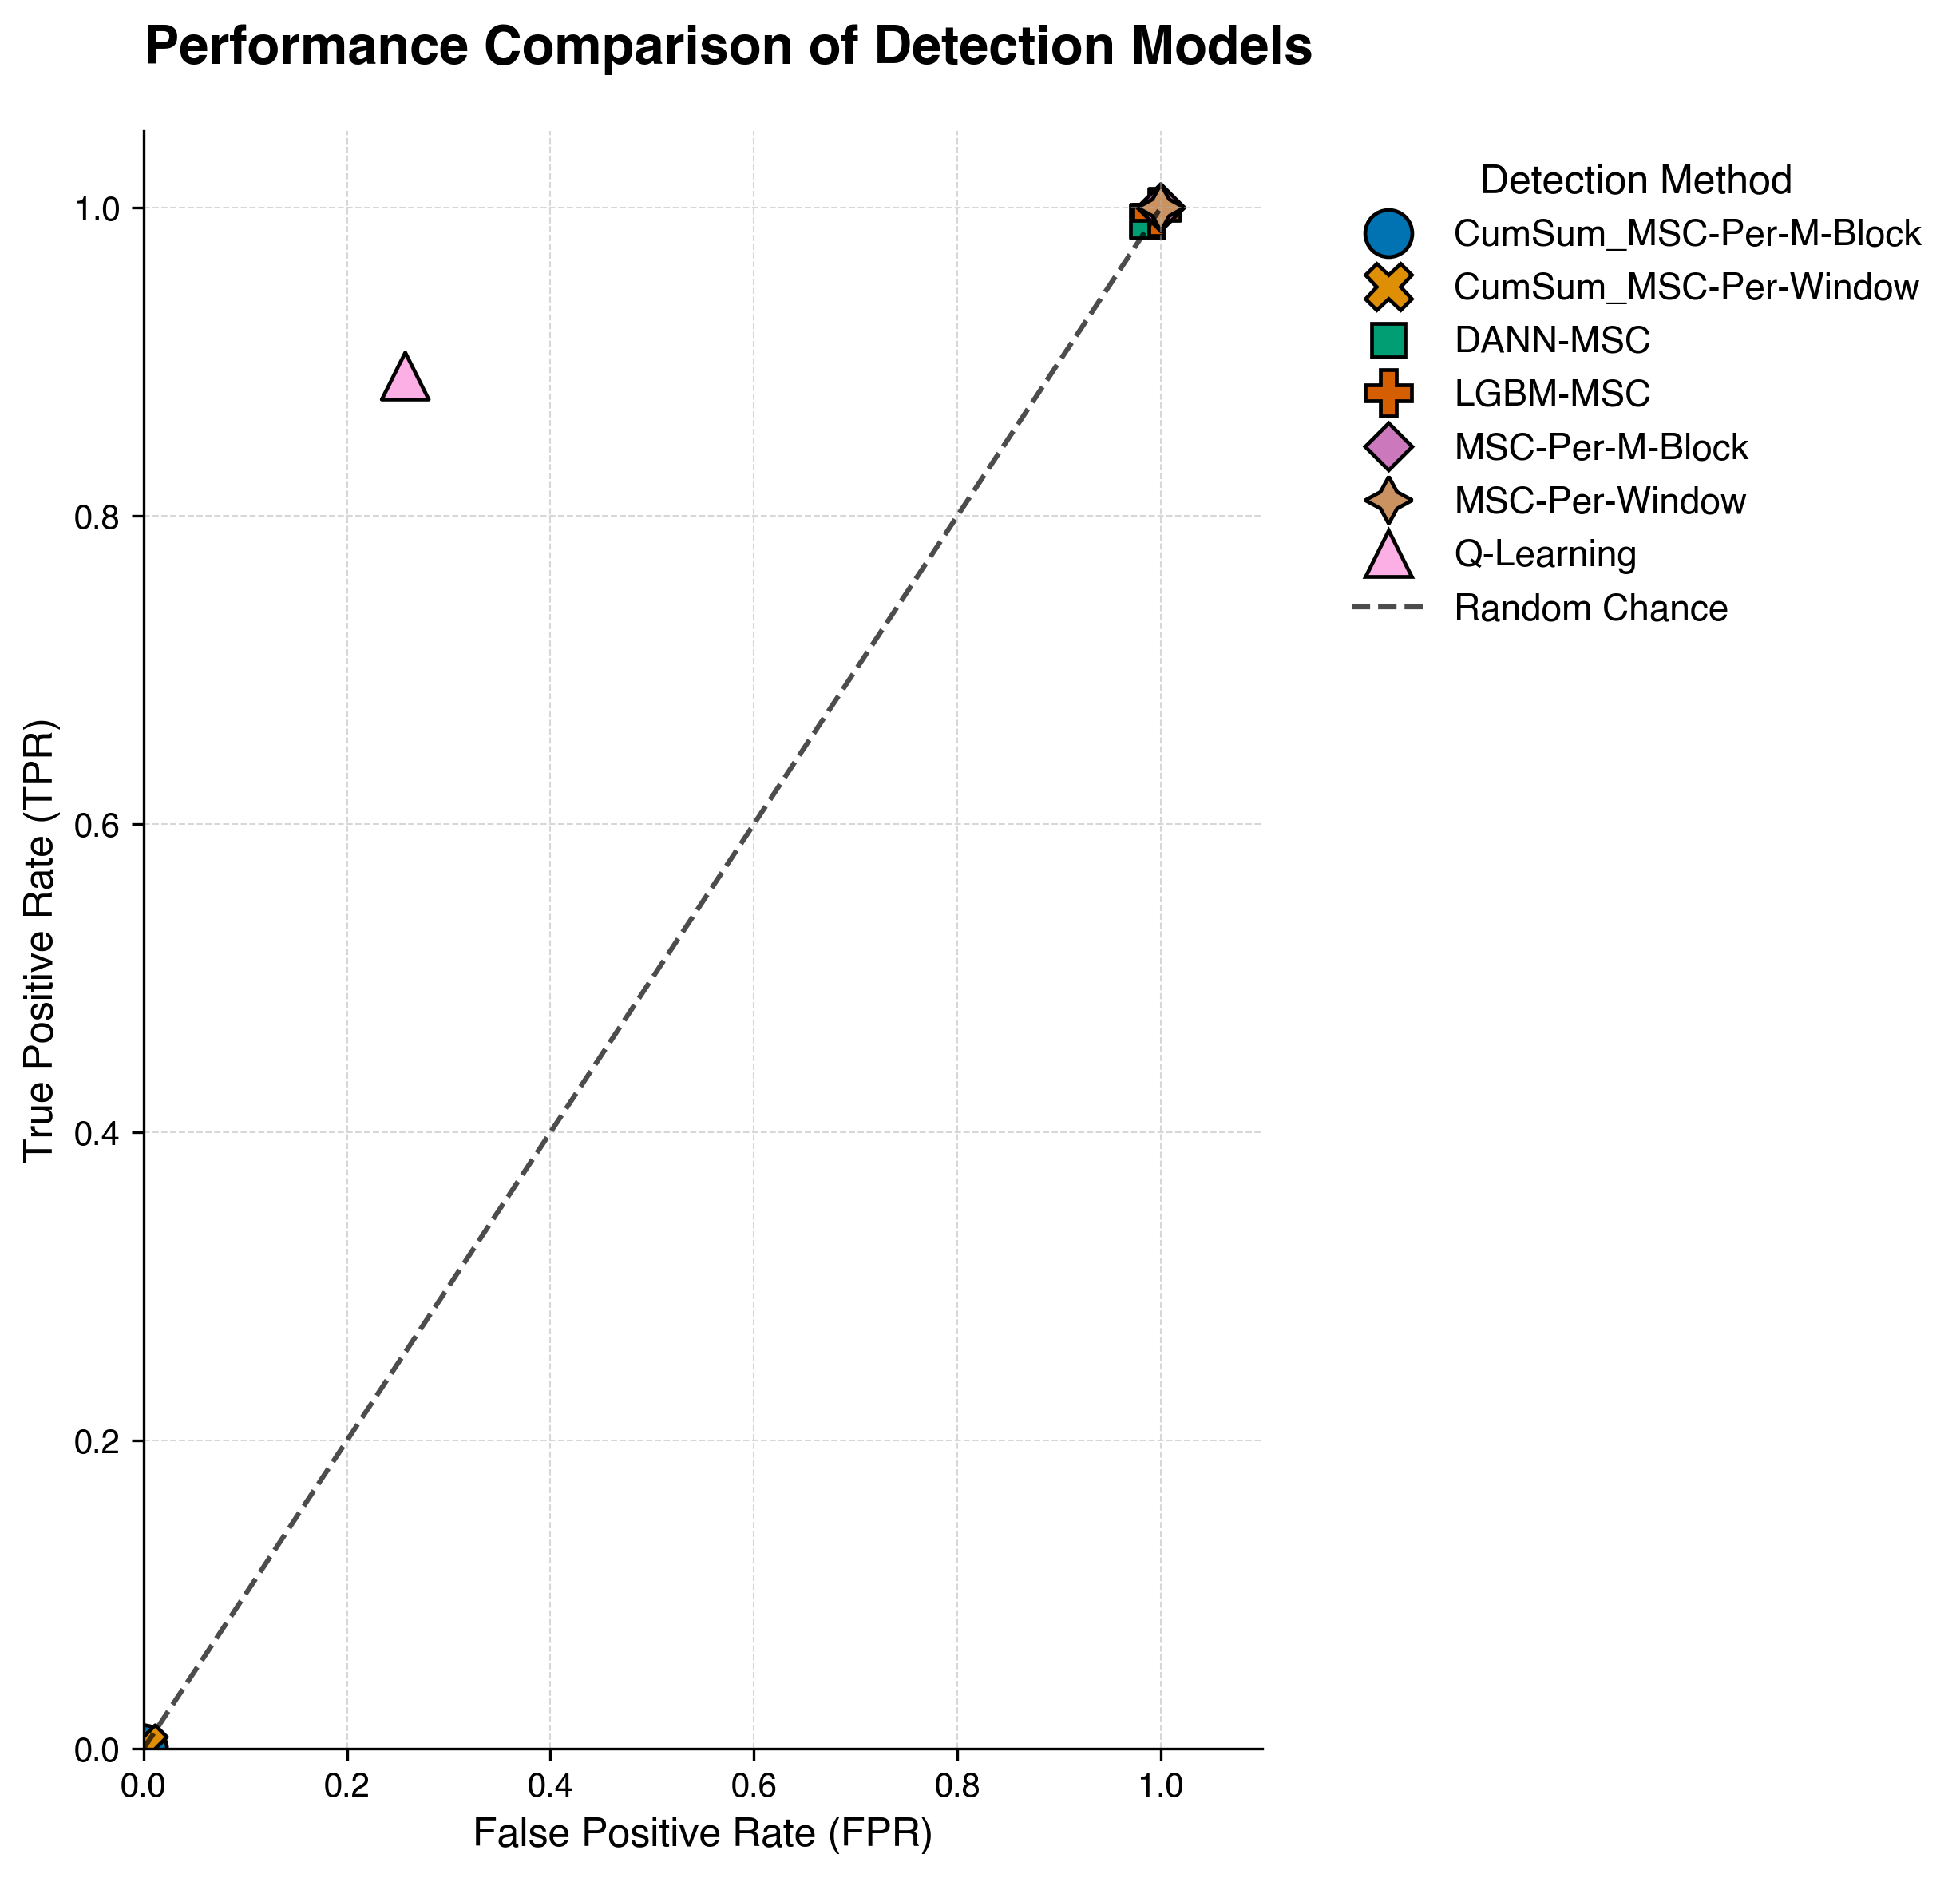


Total analysis execution finished in 2.89 minutes.


In [1]:
# main.py (Final Version with Q-Learning Integration)
"""
Main executable script for the seq-test-lib library.
"""
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.fft import fft

# --- All seqtestlib imports ---
from seqtestlib import config
from seqtestlib.data.loaders import SimulatedLoader
from seqtestlib.models import ml, dl, statistical
from seqtestlib.sequential import testers
from seqtestlib.evaluation import validators
from seqtestlib.visualization import performance, style

# --- START: Q-LEARNING MODEL AND SIMULATION CODE ---
# This section contains the complete Q-learning code you provided.

def generate_simulated_eeg(duration=1.0, sampling_rate=1000, stim_freq=40.0, noise_freq=100.0, snr_db=5.0):
    num_samples = int(duration * sampling_rate)
    time_vec = np.linspace(0, duration, num_samples, endpoint=False)
    stimulus_signal = np.sin(2 * np.pi * stim_freq * time_vec)
    signal_power = np.mean(stimulus_signal**2)
    if signal_power == 0: signal_power = 1e-10
    signal_power_db = 10 * np.log10(signal_power)
    noise_power_db = signal_power_db - snr_db
    noise_power = 10**(noise_power_db / 10)
    noise = np.random.normal(0, np.sqrt(noise_power), num_samples)
    measured_eeg = stimulus_signal + noise
    return measured_eeg, stim_freq, noise_freq, sampling_rate

def calculate_state_metrics(eeg_window, sampling_rate, target_freq):
    n_samples = len(eeg_window)
    if n_samples == 0: return 0, 0, 0
    yf = fft(eeg_window)
    xf = np.fft.fftfreq(n_samples, 1 / sampling_rate)
    freq_idx = np.argmin(np.abs(xf - target_freq))
    csm_val = np.abs(yf[freq_idx]) / n_samples
    power_at_freq = np.abs(yf[freq_idx])**2
    total_power = np.sum(np.abs(yf)**2)
    gft_val = power_at_freq / (total_power - power_at_freq) if (total_power - power_at_freq) > 1e-9 else 0
    noise_power_est = np.mean(np.abs(yf[max(0, freq_idx-10):freq_idx-5])**2) + np.mean(np.abs(yf[freq_idx+5:min(len(yf), freq_idx+10)])**2)
    msc_val = power_at_freq / (power_at_freq + noise_power_est) if (power_at_freq + noise_power_est) > 1e-9 else 0
    return csm_val, gft_val, msc_val

class QLearningAgent:
    def __init__(self, n_levels=10, n_actions=2, learning_rate=0.005, discount_factor=0.5):
        self.q_table = np.zeros((n_levels, n_levels, n_levels, n_actions))
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.n_levels = n_levels
    def discretize_state(self, csm, gft, msc, csm_bins, gft_bins, msc_bins):
        csm_level = np.digitize(csm, csm_bins)
        gft_level = np.digitize(gft, gft_bins)
        msc_level = np.digitize(msc, msc_bins)
        return (np.clip(csm_level, 0, self.n_levels - 1), np.clip(gft_level, 0, self.n_levels - 1), np.clip(msc_level, 0, self.n_levels - 1))
    def choose_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon: return np.random.choice([0, 1])
        else: return np.argmax(self.q_table[state])
    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[state][action] = new_value

def run_q_learning_simulation(snr_levels, n_episodes=500):
    """
    Runs the full Q-learning simulation across different SNR levels and returns
    a DataFrame with the final performance metrics.
    """
    print("\n--- Starting Q-Learning Agent Simulation ---")
    q_results = []
    
    for snr in tqdm(snr_levels, desc="Simulating Q-Learning Agent SNRs"):
        agent = QLearningAgent(learning_rate=0.005, discount_factor=0.5)
        csm_bins, gft_bins, msc_bins = np.linspace(0, 0.4, 9), np.linspace(0, 0.1, 9), np.linspace(0.1, 0.9, 9)
        
        # We can run fewer episodes for evaluation after training, but for simplicity
        # we re-train for each SNR to get a stable estimate.
        final_drs, final_fprs = [], []
        for episode in range(n_episodes):
            epsilon = 0.2 * np.exp(-0.5 * np.log10(episode + 1)) if episode > 0 else 0.2
            detection_count, fp_count = 0, 0
            eeg, stim_freq, noise_freq, fs = generate_simulated_eeg(duration=40.0, snr_db=snr, sampling_rate=1000)
            windows = [eeg[i:i + 1000] for i in range(0, len(eeg), 1000)]
            
            for i in range(len(windows) - 1):
                csm, gft, msc = calculate_state_metrics(windows[i], fs, stim_freq)
                current_state = agent.discretize_state(csm, gft, msc, csm_bins, gft_bins, msc_bins)
                action = agent.choose_action(current_state, epsilon)
                if action == 1: detection_count += 1
                
                csm_n, gft_n, msc_n = calculate_state_metrics(windows[i], fs, noise_freq)
                noise_state = agent.discretize_state(csm_n, gft_n, msc_n, csm_bins, gft_bins, msc_bins)
                noise_action = agent.choose_action(noise_state, 0) # Use greedy policy for FP check
                if noise_action == 1: fp_count += 1

                dr = (detection_count / (i + 1)); fpr = (fp_count / (i + 1))
                reward = (dr**2) - (fpr**2) - ((i + 1) / 40)
                
                next_csm, next_gft, next_msc = calculate_state_metrics(windows[i+1], fs, stim_freq)
                next_state_stim = agent.discretize_state(next_csm, next_gft, next_msc, csm_bins, gft_bins, msc_bins)
                agent.update_q_table(current_state, action, reward, next_state_stim)
            
            final_drs.append(detection_count / 40)
            final_fprs.append(fp_count / 40)
            
        # Average the performance over the last episodes for stability
        stable_tpr = np.mean(final_drs[-50:])
        stable_fpr = np.mean(final_fprs[-50:])
        
        q_results.append({'SNR': snr, 'TPR': stable_tpr, 'FPR': stable_fpr, 'Feature': 'Q-Learning'})
        
    print("Q-Learning simulation complete.")
    return pd.DataFrame(q_results)

# --- END: Q-LEARNING CODE ---


def run_full_analysis():
    start_time = time.time()
    print("--- Starting Unified ORD Detection Analysis ---")

    loader = SimulatedLoader(config.SIMULATED_FEATURES_FILE)
    base_feature_idx = 0 if config.BASE_METHOD_FOR_PLOTS == 'MSC' else 1
    base_feature_name = config.BASE_METHOD_FOR_PLOTS

    analysis_jobs = []
    feature_map = {'MSC': 0, 'CSM': 1, 'CumSum_MSC': 2, 'CumSum_CSM': 3}
    for approach in [{'window_type': 'Sliding', 'detection_method': 'Per-Window'}, {'window_type': 'Fixed', 'detection_method': 'Per-M-Block'}]:
        for feature in [f'{base_feature_name}', f'CumSum_{base_feature_name}']:
            analysis_jobs.append({'feature_name': f"{feature}-{approach['detection_method']}", 'model_type': 'statistical', 'feature_idx': feature_map.get(feature, 0), 'm_val': 18, **approach})
    
    analysis_jobs.extend([
        {'feature_name': f'DANN-{base_feature_name}', 'model_type': 'dann', 'feature_idx': base_feature_idx, 'm_val': config.ML_WINDOW_SIZE, 'window_type': 'Sliding', 'detection_method': 'Per-Window', 'max_samples': 10000},
        {'feature_name': f'LGBM-{base_feature_name}', 'model_type': 'lgbm', 'feature_idx': base_feature_idx, 'm_val': config.ML_WINDOW_SIZE, 'window_type': 'Sliding', 'detection_method': 'Per-Window', 'max_samples': 100000}
    ])
    
    all_results_list = []
    
    for job in tqdm(analysis_jobs, desc="Processing Analysis Jobs"):
        if job['model_type'] == 'lgbm': model = ml.LGBMModel()
        elif job['model_type'] == 'dann': model = dl.DANNModel(input_dim=job['m_val'], num_domains=len(loader.snr_keys))
        else: model = statistical.StatisticalModel()
        
        tester = testers.BlockTester(model, config.ALPHA_LEVELS[1], m_block_size=job['m_val']) if job['detection_method'] == 'Per-M-Block' else testers.StandardTester(model, config.ALPHA_LEVELS[1])
        evaluator = validators.Evaluator(tester, job['m_val'])
        job_results_df = evaluator.run_simulated_cv(loader, job)
        all_results_list.append(job_results_df)

    all_results_df = pd.concat(all_results_list, ignore_index=True)

    # --- Run Q-Learning Simulation and Combine Results ---
    snr_levels_for_q = [float(key.replace('snr_', '')) for key in loader.snr_keys]
    q_learning_results_df = run_q_learning_simulation(snr_levels=snr_levels_for_q)
    
    # Combine all results into a single DataFrame for plotting
    final_results_df = pd.concat([all_results_df, q_learning_results_df], ignore_index=True)

    # --- Consolidate and Plot ---
    print(f"\n--- Evaluation complete. Found {len(final_results_df)} total result entries. ---")
    final_results_df.to_csv('simulation_results_with_q.csv', index=False)
    print("Full results saved to 'simulation_results_with_q.csv'")

    print("\nGenerating final unified performance plot...")
    try:
        performance.plot_simulation_results(final_results_df)
    except Exception as e:
        print(f"An error occurred during plotting: {e}")

    end_time = time.time()
    print(f"\nTotal analysis execution finished in {(end_time - start_time) / 60:.2f} minutes.")

if __name__ == '__main__':
    run_full_analysis()